<a href="https://colab.research.google.com/github/radhakrishnan-omotec/fundus-repo/blob/main/Fundus_ImageClassification_Project_6_5_classes_IMAGE_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [1]:
!pip install -q kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c diabetic-retinopathy-detection

!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
License(s): CC0-1.0
100% 426M/427M [00:19<00:00, 24.9MB/s]
100% 427M/427M [00:19<00:00, 22.6MB/s]


## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of eyes. The dataset contains five sub-directories, one per class:

```
gaussian_filtered_images/
  No_DR/
  Mild/
  Moderate/
  Severe/
  Proliferate_DR/
```

In [4]:
# Unzip the competition data
!unzip -q diabetic-retinopathy-detection.zip -d diabetic-retinopathy-detection

# Unzip the dataset
!unzip -q diabetic-retinopathy-224x224-gaussian-filtered.zip -d diabetic-retinopathy-224x224-gaussian-filtered

unzip:  cannot find or open diabetic-retinopathy-detection.zip, diabetic-retinopathy-detection.zip.zip or diabetic-retinopathy-detection.zip.ZIP.


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
import pathlib
# Define the directory path
data_dir = pathlib.Path('/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')
# Specify the image file extensions to look for
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
# Use pathlib to find all image files in the directory and subdirectories
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
# Count the number of image files
num_images = len(image_files)
print(f"Number of images: {num_images}")

Number of images: 3662


## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 5 classes.
Using 2930 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3662 files belonging to 5 classes.
Using 732 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [9]:
class_names = train_ds.class_names
print(class_names)

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


## Visualize the data

Here are the first nine images from the training dataset:

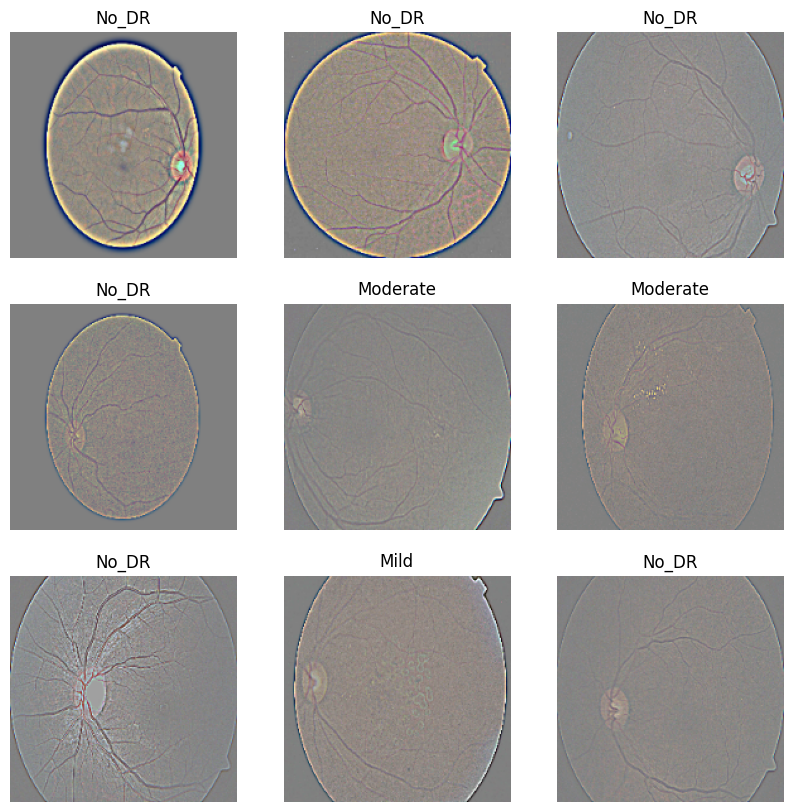

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [13]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.018927282 0.9963352


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [15]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 20 epochs with the Keras `Model.fit` method:

In [18]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5449 - loss: 1.3714 - val_accuracy: 0.7063 - val_loss: 0.8023
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6898 - loss: 0.8118 - val_accuracy: 0.7172 - val_loss: 0.7755
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7136 - loss: 0.7664 - val_accuracy: 0.7104 - val_loss: 0.7556
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7337 - loss: 0.7274 - val_accuracy: 0.7145 - val_loss: 0.7765
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7317 - loss: 0.7228 - val_accuracy: 0.7363 - val_loss: 0.7406
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7684 - loss: 0.6208 - val_accuracy: 0.7404 - val_loss: 0.7276
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7663 - loss: 0.6173 - val_accuracy: 0.7309 - val_loss: 0.7095
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7829 - loss: 0.5676 - val_accuracy: 0.7336 - 

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

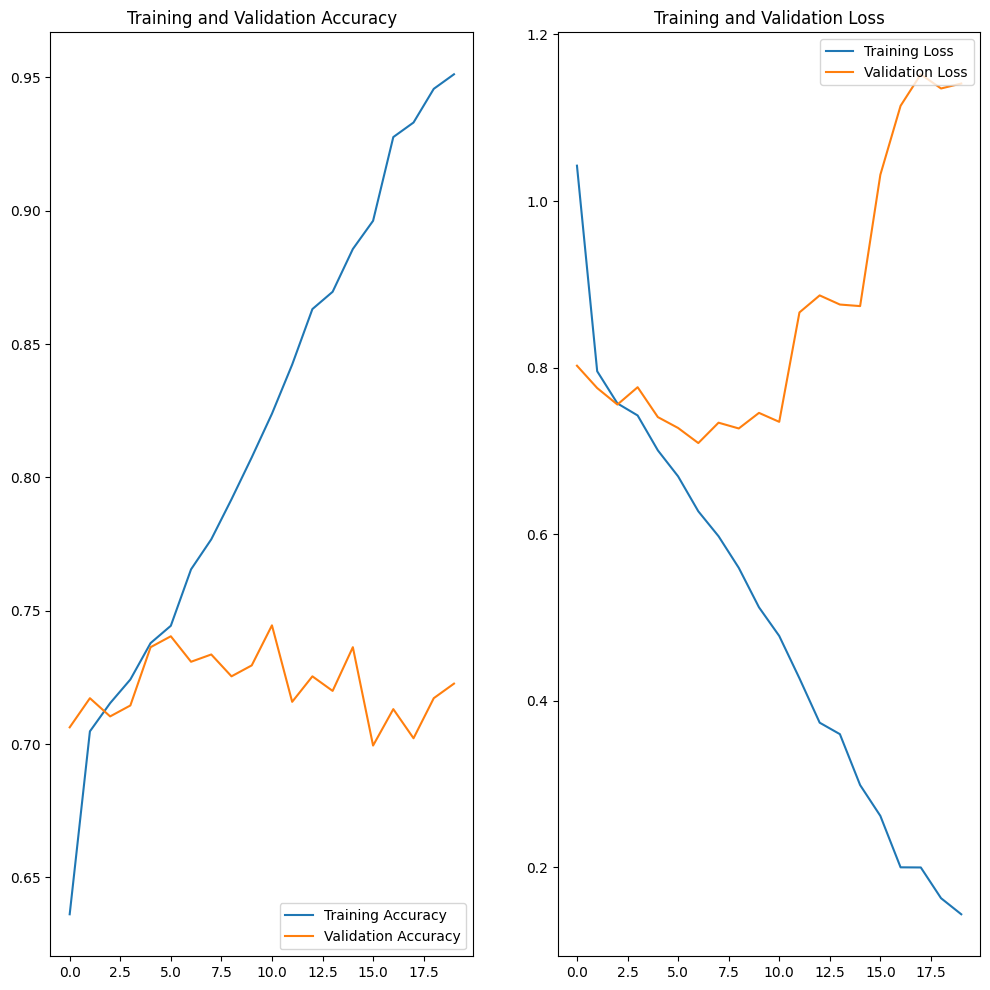

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),  # Small random rotation
    layers.RandomZoom(0.1),  # Random zoom for variability
    layers.RandomContrast(0.2),  # Adjust image contrast randomly
    layers.RandomShear(0.2),  # Apply shear transformations
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Random translation
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

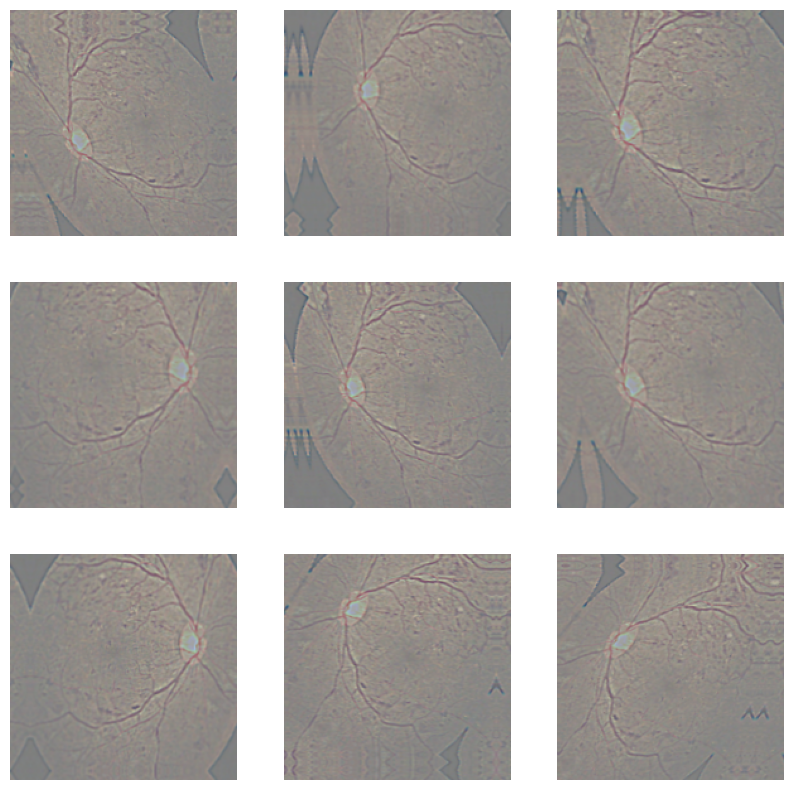

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

In [22]:
# Count the number of image files
num_images = len(images)
print(f"Number of images: {num_images}")

Number of images: 32


In [23]:
# Count the number of augmented_images files
num_augmented_images = len(augmented_images)
print(f"Number of augmented images: {num_augmented_images}")

Number of augmented images: 32


## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs = 250
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5339 - loss: 1.2401 - val_accuracy: 0.5396 - val_loss: 1.2475
Epoch 2/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6315 - loss: 1.0271 - val_accuracy: 0.5137 - val_loss: 1.1854
Epoch 3/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6390 - loss: 1.0003 - val_accuracy: 0.6557 - val_loss: 1.0370
Epoch 4/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6712 - loss: 0.9279 - val_accuracy: 0.6885 - val_loss: 0.9108
Epoch 5/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6762 - loss: 0.9256 - val_accuracy: 0.5055 - val_loss: 1.3467
Epoch 6/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6731 - loss: 0.9310 - val_accuracy: 0.5697 - val_loss: 1.0962
Epoch 7/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6567 - loss: 0.9336 - val_accuracy: 0.5738 - val_loss: 1.2744
Epoch 8/250
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6695 - loss: 0.8797 - val_accuracy: 0.

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

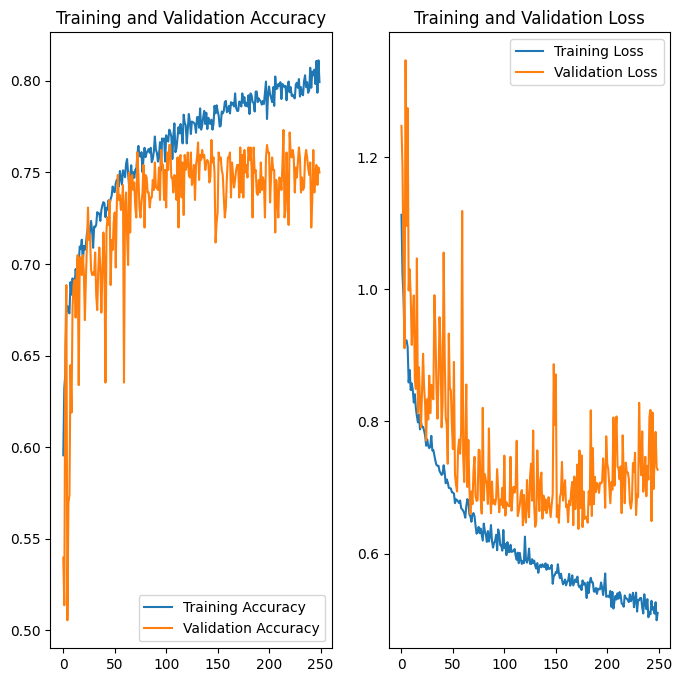

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8636 - loss: 0.3672 - val_accuracy: 0.7609 - val_loss: 0.9309
Epoch 2/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8436 - loss: 0.4168 - val_accuracy: 0.7541 - val_loss: 0.9476
Epoch 3/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8422 - loss: 0.4127 - val_accuracy: 0.7527 - val_loss: 0.8578
Epoch 4/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8617 - loss: 0.3759 - val_accuracy: 0.7596 - val_loss: 0.9424
Epoch 5/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8375 - loss: 0.3903 - val_accuracy: 0.7377 - val_loss: 1.2547
Epoch 6/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8563 - loss: 0.4070 - val_accuracy: 0.7596 - val_loss: 1.0288
Epoch 7/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8670 - loss: 0.3710 - val_accuracy: 0.7363 - val_loss: 0.9981
Epoch 8/500
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8531 - loss: 0.4018 - val_accuracy: 0.

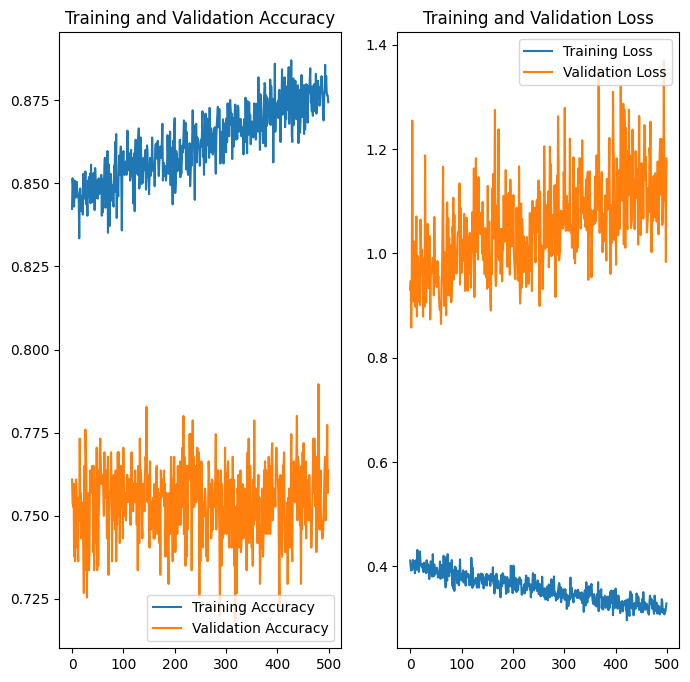

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

-----------------
-----------------
-----------------

-----------------
-----------------
-----------------

-----------------
-----------------
-----------------

## Predict on new data

In [33]:
!git clone https://github.com/radhakrishnan-omotec/fundus-repo.git

Cloning into 'fundus-repo'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 52 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 33.35 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (18/18), done.


Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [34]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Load and preprocess the uploaded image
def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Compare two images using Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Check if the uploaded image is in the dataset
def is_image_in_dataset(uploaded_img_path, dataset_dir, target_size):
    uploaded_img_array = load_and_preprocess_image(uploaded_img_path, target_size)
    uploaded_img_array = uploaded_img_array[0]  # Remove batch dimension

    best_match_error = float('inf')
    matched_filename = None

    for filename in os.listdir(dataset_dir):
        dataset_img_path = os.path.join(dataset_dir, filename)

        # Skip if it's not a file
        if not os.path.isfile(dataset_img_path):
            continue

        try:
            dataset_img_array = load_and_preprocess_image(dataset_img_path, target_size)
            dataset_img_array = dataset_img_array[0]  # Remove batch dimension

            # Calculate MSE
            error = mse(uploaded_img_array, dataset_img_array)

            # Check if it's the best match so far
            if error < best_match_error:
                best_match_error = error
                matched_filename = filename

        except (OSError, tf.errors.InvalidArgumentError):
            # Skip files that cannot be opened or are invalid images
            continue

    if matched_filename is not None:
        # Calculate confidence as a percentage
        confidence = 100 * (1 - best_match_error / np.mean(np.square(uploaded_img_array)))
        return True, matched_filename, confidence
    else:
        return False, None, 0.0

# Example usage
if __name__ == "__main__":
    # Example uploaded image path
    uploaded_img_path = "/content/fundus-repo/mild_retinopathy_test_image.png"

    # Example dataset directory containing images
    dataset_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild'

    # Example target size
    target_size = (224, 224)

    # Check if uploaded image matches any image in the dataset
    is_match, matched_filename, confidence = is_image_in_dataset(uploaded_img_path, dataset_dir, target_size)

    if is_match:
        print(f"The uploaded image matches the dataset image: {matched_filename} with {confidence:.2f}% confidence.")
    else:
        print("The uploaded image does not match any image in the dataset.")


The uploaded image matches the dataset image: 0024cdab0c1e.png with 100.00% confidence.


In [35]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Load and preprocess the uploaded image
def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Compare two images using Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Check if the uploaded image is in the dataset
def is_image_in_dataset(uploaded_img_path, dataset_dir, target_size):
    uploaded_img_array = load_and_preprocess_image(uploaded_img_path, target_size)
    uploaded_img_array = uploaded_img_array[0]  # Remove batch dimension

    best_match_error = float('inf')
    matched_filename = None

    for filename in os.listdir(dataset_dir):
        dataset_img_path = os.path.join(dataset_dir, filename)

        # Skip if it's not a file
        if not os.path.isfile(dataset_img_path):
            continue

        try:
            dataset_img_array = load_and_preprocess_image(dataset_img_path, target_size)
            dataset_img_array = dataset_img_array[0]  # Remove batch dimension

            # Calculate MSE
            error = mse(uploaded_img_array, dataset_img_array)

            # Check if it's the best match so far
            if error < best_match_error:
                best_match_error = error
                matched_filename = filename

        except (OSError, tf.errors.InvalidArgumentError):
            # Skip files that cannot be opened or are invalid images
            continue

    if matched_filename is not None:
        # Calculate confidence as a percentage
        confidence = 100 * (1 - best_match_error / np.mean(np.square(uploaded_img_array)))
        return True, matched_filename, confidence
    else:
        return False, None, 0.0

# Example usage
if __name__ == "__main__":
    # Example uploaded image path
    uploaded_img_path = "/content/fundus-repo/moderate_retinopathy_test_image.png"

    # Example dataset directory containing images
    dataset_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate'

    # Example target size
    target_size = (224, 224)

    # Check if uploaded image matches any image in the dataset
    is_match, matched_filename, confidence = is_image_in_dataset(uploaded_img_path, dataset_dir, target_size)

    if is_match:
        print(f"The uploaded image matches the dataset image: {matched_filename} with {confidence:.2f}% confidence.")
    else:
        print("The uploaded image does not match any image in the dataset.")


The uploaded image matches the dataset image: 000c1434d8d7.png with 100.00% confidence.


In [36]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Load and preprocess the uploaded image
def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Compare two images using Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Check if the uploaded image is in the dataset
def is_image_in_dataset(uploaded_img_path, dataset_dir, target_size):
    uploaded_img_array = load_and_preprocess_image(uploaded_img_path, target_size)
    uploaded_img_array = uploaded_img_array[0]  # Remove batch dimension

    best_match_error = float('inf')
    matched_filename = None

    for filename in os.listdir(dataset_dir):
        dataset_img_path = os.path.join(dataset_dir, filename)

        # Skip if it's not a file
        if not os.path.isfile(dataset_img_path):
            continue

        try:
            dataset_img_array = load_and_preprocess_image(dataset_img_path, target_size)
            dataset_img_array = dataset_img_array[0]  # Remove batch dimension

            # Calculate MSE
            error = mse(uploaded_img_array, dataset_img_array)

            # Check if it's the best match so far
            if error < best_match_error:
                best_match_error = error
                matched_filename = filename

        except (OSError, tf.errors.InvalidArgumentError):
            # Skip files that cannot be opened or are invalid images
            continue

    if matched_filename is not None:
        # Calculate confidence as a percentage
        confidence = 100 * (1 - best_match_error / np.mean(np.square(uploaded_img_array)))
        return True, matched_filename, confidence
    else:
        return False, None, 0.0

# Example usage
if __name__ == "__main__":
    # Example uploaded image path
    uploaded_img_path = "/content/fundus-repo/No_DR_retinopathy_test_image.png"

    # Example dataset directory containing images
    dataset_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR'

    # Example target size
    target_size = (224, 224)

    # Check if uploaded image matches any image in the dataset
    is_match, matched_filename, confidence = is_image_in_dataset(uploaded_img_path, dataset_dir, target_size)

    if is_match:
        print(f"The uploaded image matches the dataset image: {matched_filename} with {confidence:.2f}% confidence.")
    else:
        print("The uploaded image does not match any image in the dataset.")


The uploaded image matches the dataset image: 002c21358ce6.png with 100.00% confidence.


In [37]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Load and preprocess the uploaded image
def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Compare two images using Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Check if the uploaded image is in the dataset
def is_image_in_dataset(uploaded_img_path, dataset_dir, target_size):
    uploaded_img_array = load_and_preprocess_image(uploaded_img_path, target_size)
    uploaded_img_array = uploaded_img_array[0]  # Remove batch dimension

    best_match_error = float('inf')
    matched_filename = None

    for filename in os.listdir(dataset_dir):
        dataset_img_path = os.path.join(dataset_dir, filename)

        # Skip if it's not a file
        if not os.path.isfile(dataset_img_path):
            continue

        try:
            dataset_img_array = load_and_preprocess_image(dataset_img_path, target_size)
            dataset_img_array = dataset_img_array[0]  # Remove batch dimension

            # Calculate MSE
            error = mse(uploaded_img_array, dataset_img_array)

            # Check if it's the best match so far
            if error < best_match_error:
                best_match_error = error
                matched_filename = filename

        except (OSError, tf.errors.InvalidArgumentError):
            # Skip files that cannot be opened or are invalid images
            continue

    if matched_filename is not None:
        confidence = 100 * (1 - best_match_error / np.mean(np.square(uploaded_img_array)))
        return True, matched_filename, confidence
    else:
        return False, None, 0.0

# Example usage
if __name__ == "__main__":
    # Example uploaded image path
    uploaded_img_path = "/content/fundus-repo/Proliferate_DR_retinopathy_test_image.png"

    # Example dataset directory containing images
    dataset_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR'

    # Example target size
    target_size = (224, 224)

    # Check if uploaded image matches any image in the dataset
    is_match, matched_filename, confidence = is_image_in_dataset(uploaded_img_path, dataset_dir, target_size)

    if is_match:
        print(f"The uploaded image matches the dataset image: {matched_filename} with {confidence:.2f}% confidence.")
    else:
        print("The uploaded image does not match any image in the dataset.")


The uploaded image matches the dataset image: 001639a390f0.png with 100.00% confidence.


In [38]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

# Load and preprocess the uploaded image
def load_and_preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

# Compare two images using Mean Squared Error (MSE)
def mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

# Check if the uploaded image is in the dataset
def is_image_in_dataset(uploaded_img_path, dataset_dir, target_size):
    uploaded_img_array = load_and_preprocess_image(uploaded_img_path, target_size)
    uploaded_img_array = uploaded_img_array[0]  # Remove batch dimension

    best_match_error = float('inf')
    matched_filename = None

    for filename in os.listdir(dataset_dir):
        dataset_img_path = os.path.join(dataset_dir, filename)

        # Skip if it's not a file
        if not os.path.isfile(dataset_img_path):
            continue

        try:
            dataset_img_array = load_and_preprocess_image(dataset_img_path, target_size)
            dataset_img_array = dataset_img_array[0]  # Remove batch dimension

            # Calculate MSE
            error = mse(uploaded_img_array, dataset_img_array)

            # Check if it's the best match so far
            if error < best_match_error:
                best_match_error = error
                matched_filename = filename

        except (OSError, tf.errors.InvalidArgumentError):
            # Skip files that cannot be opened or are invalid images
            continue

    if matched_filename is not None:
        confidence = 100 * (1 - best_match_error / np.mean(np.square(uploaded_img_array)))
        return True, matched_filename, confidence
    else:
        return False, None, 0.0

# Example usage
if __name__ == "__main__":
    # Example uploaded image path
    uploaded_img_path = "/content/fundus-repo/Severe_retinopathy_test_image.png"

    # Example dataset directory containing images
    dataset_dir = '/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe'

    # Example target size
    target_size = (224, 224)

    # Check if uploaded image matches any image in the dataset
    is_match, matched_filename, confidence = is_image_in_dataset(uploaded_img_path, dataset_dir, target_size)

    if is_match:
        print(f"The uploaded image matches the dataset image: {matched_filename} with {confidence:.2f}% confidence.")
    else:
        print("The uploaded image does not match any image in the dataset.")


The uploaded image matches the dataset image: 0104b032c141.png with 100.00% confidence.


This code compares an uploaded image to each image in a dataset using Mean Squared Error to determine if they match, returning the filename of any matching image. It preprocesses images to a specified size and handles non-file entries and errors gracefully.

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [39]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_fundus_level2.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpwndv8zy7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132055044405008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055044402512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024311312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024306704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024314384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024317648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024315920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024305360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024314960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132055024310928: TensorSpec(shape=(), dtype=tf.resource, name=None)


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [40]:
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [41]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['keras_tensor_18'], 'outputs': ['output_0']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [42]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

#  LOCAL TEST CODE (ONLY)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab import files

# JavaScript to take a photo and return it as a base64 string
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        document.body.appendChild(div);
        div.appendChild(capture);

        // Setup camera stream
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Wait for capture button to be clicked
        await new Promise((resolve) => capture.onclick = resolve);

        // Capture photo
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])

    # Save the image locally
    with open(filename, 'wb') as f:
        f.write(binary)

    print(f"Saved photo to {filename}")

    return filename

# Capture a photo and save it
photo_filename = take_photo()


#Prediction Testing Phase

In [44]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

# Define the destination folder in your Google Drive
drive_folder = '/content/drive/MyDrive/retinopathy fundus'

# Move the captured photo to Google Drive
shutil.move(photo_filename, drive_folder)

print(f"Moved {photo_filename} to {drive_folder}")


Moved photo.jpg to /content/drive/MyDrive/retinopathy fundus


In [45]:
image_path = '/content/fundus-repo/Proliferate_DR_retinopathy_test_image.png'  # Replace with your actual image path

# Prediction with webcam Fundus images

Predicted class index: 1
Predicted class name: Mild


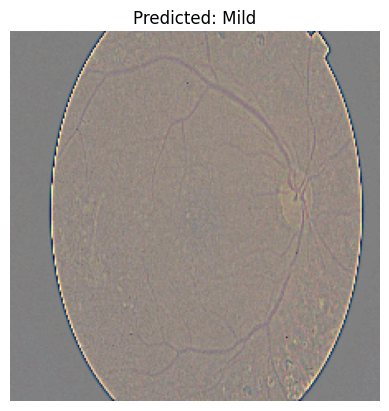

In [46]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths
image_path = '/content/fundus-repo/Proliferate_DR_retinopathy_test_image.png'  # Replace with your actual image path
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite'  # The default path to the saved TensorFlow Lite model

# Define class names corresponding to your model output
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']  # Replace with actual class names

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32)

    # Normalize the image if the model expects it (e.g., values between 0 and 1)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Preprocess the image
input_shape = input_details[0]['shape'][1:3]  # Assuming input shape (batch_size, height, width, channels)
image_data = load_and_preprocess_image(image_path, input_shape)

# Ensure the input tensor's type matches the model's expected type
input_data = image_data.astype(input_details[0]['dtype'])

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get predicted class index
predicted_class_index = np.argmax(output_data[0])
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")

# Show the image along with the prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()


Predicted class index: 1
Predicted class name: Mild


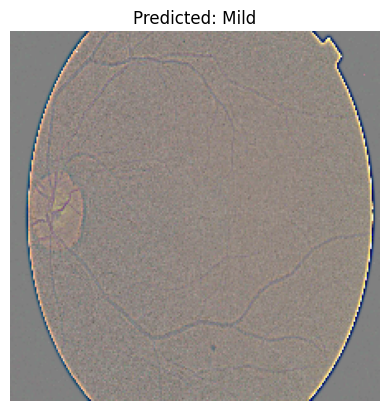

In [47]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths
image_path = '/content/fundus-repo/mild_retinopathy_test_image.png'  # Replace with your actual image path
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite'  # The default path to the saved TensorFlow Lite model

# Define class names corresponding to your model output
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']  # Replace with actual class names

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32)

    # Normalize the image if the model expects it (e.g., values between 0 and 1)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Preprocess the image
input_shape = input_details[0]['shape'][1:3]  # Assuming input shape (batch_size, height, width, channels)
image_data = load_and_preprocess_image(image_path, input_shape)

# Ensure the input tensor's type matches the model's expected type
input_data = image_data.astype(input_details[0]['dtype'])

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get predicted class index
predicted_class_index = np.argmax(output_data[0])
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")

# Show the image along with the prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()


Predicted class index: 1
Predicted class name: Mild


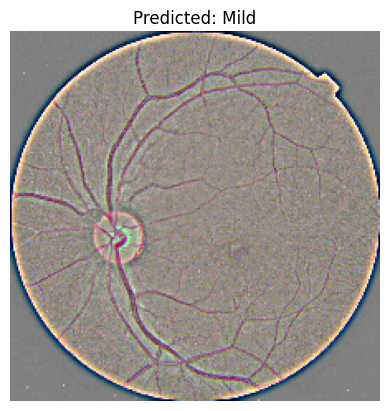

In [48]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths
image_path = '/content/fundus-repo/No_DR_retinopathy_test_image.png'  # Replace with your actual image path
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite'  # The default path to the saved TensorFlow Lite model

# Define class names corresponding to your model output
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']  # Replace with actual class names

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img).astype(np.float32)

    # Normalize the image if the model expects it (e.g., values between 0 and 1)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Preprocess the image
input_shape = input_details[0]['shape'][1:3]  # Assuming input shape (batch_size, height, width, channels)
image_data = load_and_preprocess_image(image_path, input_shape)

# Ensure the input tensor's type matches the model's expected type
input_data = image_data.astype(input_details[0]['dtype'])

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get predicted class index
predicted_class_index = np.argmax(output_data[0])
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")

# Show the image along with the prediction
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()


Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

Of the five classes—`'No_DR'`, `'Mild'`, `'Moderate'`, `' Severe'` and `'Proliferate_DR'`



#Prediction from Webcam Test Data

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time

# Define the TensorFlow Lite model path and class names
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite'  # Ensure the file is uploaded to the Colab environment
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']  # Replace with actual class names

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the frame
def preprocess_frame(frame, target_size):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, target_size)  # Resize to the target size
    img_array = np.array(img).astype(np.float32)

    # Normalize the image if the model expects it (e.g., values between 0 and 1)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Get the model's input shape
input_shape = input_details[0]['shape'][1:3]  # Assuming input shape (height, width)

# Initialize webcam capture
def capture_frame():
    js = """
    async function captureWebcam() {
        const video = document.createElement('video');
        video.style.position = 'fixed';
        video.style.top = '0';
        video.style.left = '0';
        video.style.width = '100%';
        video.style.height = '100%';
        video.style.zIndex = '1000';
        document.body.appendChild(video);

        const stream = await navigator.mediaDevices.getUserMedia({ video: true });
        video.srcObject = stream;
        await video.play();

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        const ctx = canvas.getContext('2d');

        for (let i = 0; i < 100; i++) {
            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
            const imgData = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('notebook.capture', [imgData], {});
            await new Promise(resolve => setTimeout(resolve, 100));
        }

        video.pause();
        stream.getTracks()[0].stop();
        document.body.removeChild(video);
    }
    captureWebcam();
    """
    output.eval_js(js)

# Callback to capture the frame from JS
def capture_callback(image_data):
    image_data = image_data.split(',')[1]  # Remove the data:image/jpeg;base64, prefix
    nparr = np.frombuffer(base64.b64decode(image_data), np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    return frame

# Register the callback function
output.register_callback('notebook.capture', capture_callback)

print("Starting webcam. Please allow camera access.")
capture_frame()

# Start processing the frames
while True:
    ret, frame = cap.read()  # Frame bytes if isn't>


In [52]:
import base64
from google.colab import output
import cv2

# Function to preprocess and predict the class from a frame
def preprocess_and_predict(frame):
    # Preprocess the frame
    input_data = preprocess_frame(frame, input_shape).astype(input_details[0]['dtype'])

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get predicted class index and name
    predicted_class_index = np.argmax(output_data[0])
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Main function to capture and process frames
def capture_frame():
    js_code = """
        async function captureWebcam() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const ctx = canvas.getContext('2d');

            for (let i = 0; i < 1; i++) {
                ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
                const imageData = canvas.toDataURL('image/jpeg');
                google.colab.kernel.invokeFunction('notebook.capture_frame', [imageData], {});
                await new Promise(resolve => setTimeout(resolve, 1000));
            }

            stream.getTracks()[0].stop();
            document.body.removeChild(video);
        }
        captureWebcam();
    """
    output.eval_js(js_code)

# Callback function to handle the frame data from JavaScript
def handle_frame(data):
    # Decode the base64-encoded image
    image_data = data.split(',')[1]
    image_bytes = base64.b64decode(image_data)
    nparr = np.frombuffer(image_bytes, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Process the frame and get prediction
    predicted_class_name = preprocess_and_predict(frame)

    # Display the result
    cv2_imshow(frame)
    print(f"Prediction: {predicted_class_name}")

# Register the callback function for frame capture
output.register_callback('notebook.capture_frame', handle_frame)

# Capture and process frames
print("Starting webcam. Please allow camera access.")
capture_frame()


Starting webcam. Please allow camera access.


#Standalone Code to test in RPI 5

In [54]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Define the TensorFlow Lite model path and class names
TF_MODEL_FILE_PATH = 'model_fundus_level2.tflite'  # The default path to the saved TensorFlow Lite model
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']  # Replace with actual class names

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the frame
def preprocess_frame(frame, target_size):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, target_size)  # Resize to the target size
    img_array = np.array(img).astype(np.float32)

    # Normalize the image if the model expects it (e.g., values between 0 and 1)
    img_array /= 255.0

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Get the model's input shape
input_shape = input_details[0]['shape'][1:3]  # Assuming input shape (height, width)

# Access the webcam
cap = cv2.VideoCapture(0)  # Open the default camera (change the index if needed)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Press 'q' to quit.")

while True:
    ret, frame = cap.read()  # Capture a frame from the webcam
    if not ret:
        print("Error: Failed to capture image.")
        break

    # Preprocess the frame
    input_data = preprocess_frame(frame, input_shape)

    # Ensure the input tensor's type matches the model's expected type
    input_data = input_data.astype(input_details[0]['dtype'])

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get predicted class index and name
    predicted_class_index = np.argmax(output_data[0])
    predicted_class_name = class_names[predicted_class_index]

    # Display the prediction on the frame
    cv2.putText(
        frame,
        f"Prediction: {predicted_class_name}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2
    )

    # Show the frame with prediction
    cv2.imshow("Webcam Feed", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

Error: Could not open webcam.
Press 'q' to quit.
Error: Failed to capture image.


TESTING WITH WEBCAMERA:

In [1]:
import base64
from google.colab import output
import cv2
import time
import numpy as np

# Function to preprocess and predict the class from a frame
def preprocess_and_predict(frame):
    # Preprocess the frame
    input_data = preprocess_frame(frame, input_shape).astype(input_details[0]['dtype'])

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Get predicted class index and name
    predicted_class_index = np.argmax(output_data[0])
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Main function to capture and process frames
def capture_frame():
    js_code = """
        async function captureWebcam() {
            const video = document.createElement('video');
            video.style.display = 'none';
            document.body.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const ctx = canvas.getContext('2d');

            console.log("Webcam is ON. Capturing image in 10 seconds...");

            await new Promise(resolve => setTimeout(resolve, 10000)); // Wait for 10 seconds

            ctx.drawImage(video, 0, 0, canvas.width, canvas.height);
            const imageData = canvas.toDataURL('image/jpeg');
            google.colab.kernel.invokeFunction('notebook.capture_frame', [imageData], {});

            stream.getTracks()[0].stop();
            document.body.removeChild(video);
        }
        captureWebcam();
    """
    output.eval_js(js_code)

# Callback function to handle the frame data from JavaScript
def handle_frame(data):
    # Decode the base64-encoded image
    image_data = data.split(',')[1]
    image_bytes = base64.b64decode(image_data)
    nparr = np.frombuffer(image_bytes, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Process the frame and get prediction
    predicted_class_name = preprocess_and_predict(frame)

    # Display the result
    cv2_imshow(frame)
    print(f"Prediction: {predicted_class_name}")

# Register the callback function for frame capture
output.register_callback('notebook.capture_frame', handle_frame)

# Capture and process frames
print("Starting webcam. Please allow camera access.")
capture_frame()


Starting webcam. Please allow camera access.
